In [1]:
import numpy as np
import pandas as pd 
import glob
import time
import os 
import matplotlib.pyplot as plt 
import keras
import cv2

2025-02-02 18:49:48.922013: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("XSS_dataset.csv",encoding = 'utf-8-sig')
df.head()

,Unnamed: 0,Sentence,Label
0,0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,2,"\t </span> <span class=""reference-text"">Steeri...",0
3,3,"\t </span> <span class=""reference-text""><cite ...",0
4,4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0


In [3]:
df = df[df.columns[-2:]]
df.head()

,Sentence,Label
0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,"\t </span> <span class=""reference-text"">Steeri...",0
3,"\t </span> <span class=""reference-text""><cite ...",0
4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0


In [4]:
sentences = df['Sentence'].values
sentences[1]

'<tt onmouseover="alert(1)">test</tt>'

In [5]:
print(len(sentences))

13686


In [6]:
# Convert to ASCII

# Some charecter have values very big e.d. 8221 a dn some chinese letters 
# i am removing letters having values greater than 8222 and for rest greater 
# than 128 and smaller than 8222 assigning them values so they can be easily be normalized

def convert_to_ascii(sentence):
    sentence_ascii=[]
    for i in sentence:
        if(ord(i)<8222):
            if(ord(i)==8217):
                sentence_ascii.append(134)
            if(ord(i)==8221):
                sentence_ascii.append(129)
            if(ord(i)==8220):
                sentence_ascii.append(130)
            if(ord(i)==8216):
                sentence_ascii.append(131)
            if(ord(i)==8217):
                sentence_ascii.append(132)
            if(ord(i)==8211):
                sentence_ascii.append(133)
# if values less than 128 store them else discard them
            if(ord(i)<=128):
                sentence_ascii.append(ord(i))
            else:
                pass
    zer=np.zeros((10000))
    
    for i in range(len(sentence_ascii)):
        zer[i]=sentence_ascii[i]
    zer.shape=(100,100)
    
    return zer

In [7]:
gg=convert_to_ascii(sentences[1])
print(gg)

[[ 60. 116. 116. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


In [8]:
# send each sentence to be convert to ASCII

arr=np.zeros((len(sentences),100,100))
for i in range(len(sentences)):
    image=convert_to_ascii(sentences[i])
    x=np.asarray(image,dtype='float')
    image = cv2.resize(x,dsize=(100,100),interpolation=cv2.INTER_CUBIC)
    image/=128
    arr[i]=image

In [9]:
print("Input data shape: ",arr.shape)

Input data shape:  (13686, 100, 100)


In [10]:
# Reshape data for input to CNN
data = arr.reshape(arr.shape[0],100,100,1)

In [11]:
data.shape

(13686, 100, 100, 1)

In [12]:
y=df['Label'].values

In [13]:
# Split into train/test data
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(data, y, test_size = 0.2, random_state = 42)


In [14]:
# import libreries for Making Model
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense , Activation , Conv2D, MaxPooling2D, Flatten, Dropout,MaxPool2D,BatchNormalization        

In [20]:
# A baisc CNN Model 
# Number of Layers = 11
# Number of Convolutional layer : 3 

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation = tf.nn.relu, input_shape=(100,100,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(343,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(178,activation='relu'),
    tf.keras.layers.Dense(83,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
    
])


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 256)    │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 343)    │       790,615 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 343)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 34300)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 178)            │     6,105,578 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 83)             │        14,857 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,990,795 (26.67 MB)

 Trainable params: 6,990,795 (26.67 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
batch_size = 128
num_epoch = 49
history = model.fit(trainX,trainY,
                     batch_size=batch_size,
                     epochs=num_epoch,
                     verbose=1,
                     validation_data=(testX,testY))


Epoch 1/49
86/86 ━━━━━━━━━━━━━━━━━━━━ 587s 7s/step - accuracy: 0.6978 - loss: 0.6136 - val_accuracy: 0.8039 - val_loss: 0.4035
Epoch 2/49
86/86 ━━━━━━━━━━━━━━━━━━━━ 552s 6s/step - accuracy: 0.8079 - loss: 0.4050 - val_accuracy: 0.8086 - val_loss: 0.3917
Epoch 3/49
86/86 ━━━━━━━━━━━━━━━━━━━━ 546s 6s/step - accuracy: 0.8148 - loss: 0.3918 - val_accuracy: 0.8134 - val_loss: 0.3749
Epoch 4/49
86/86 ━━━━━━━━━━━━━━━━━━━━ 548s 6s/step - accuracy: 0.8407 - loss: 0.3562 - val_accuracy: 0.8923 - val_loss: 0.2972
Epoch 5/49
86/86 ━━━━━━━━━━━━━━━━━━━━ 713s 8s/step - accuracy: 0.8917 - loss: 0.2875 - val_accuracy: 0.9149 - val_loss: 0.2024
Epoch 6/49
86/86 ━━━━━━━━━━━━━━━━━━━━ 556s 6s/step - accuracy: 0.9451 - loss: 0.1833 - val_accuracy: 0.9631 - val_loss: 0.1357
Epoch 7/49
86/86 ━━━━━━━━━━━━━━━━━━━━ 549s 6s/step - accuracy: 0.9693 - loss: 0.1186 - val_accuracy: 0.9722 - val_loss: 0.1023
Epoch 8/49
86/86 ━━━━━━━━━━━━━━━━━━━━ 541s 6s/step - accuracy: 0.9726 - loss: 0.1010 - val_accuracy: 0.9752 - v

In [25]:
plt.plot?

Signature:
plt.plot(
    *args: 'float | ArrayLike | str',
    scalex: 'bool' = True,
    scaley: 'bool' = True,
    data=None,
    **kwargs,
) -> 'list[Line2D]'
Docstring:
Plot y versus x as lines and/or markers.

Call signatures::

    plot([x], y, [fmt], *, data=None, **kwargs)
    plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)

The coordinates of the points or line nodes are given by *x*, *y*.

The optional parameter *fmt* is a convenient way for defining basic
formatting like color, marker and linestyle. It's a shortcut string
notation described in the *Notes* section below.

>>> plot(x, y)        # plot x and y using default line style and color
>>> plot(x, y, 'bo')  # plot x and y using blue circle markers
>>> plot(y)           # plot y using x as index array 0..N-1
>>> plot(y, 'r+')     # ditto, but with red plusses

You can use `.Line2D` properties as keyword arguments for more
control on the appearance. Line properties and *fmt* can be mixed.
The following two calls yie

/var/folders/1v/384676md64d312zq8xs74mkw0000gn/T/ipykernel_17241/2512394711.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'go--',color='blue', label='Training Accuracy')
/var/folders/1v/384676md64d312zq8xs74mkw0000gn/T/ipykernel_17241/2512394711.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rs" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'rs',color='orange', label='Validation Accuracy')
/var/folders/1v/384676md64d312zq8xs74mkw0000gn/T/ipykernel_17241/2512394711.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'go--', color='blue', label='Training Loss')
/var/folders/1v/384676md64d312zq8xs74mkw0000gn/T/ipykern

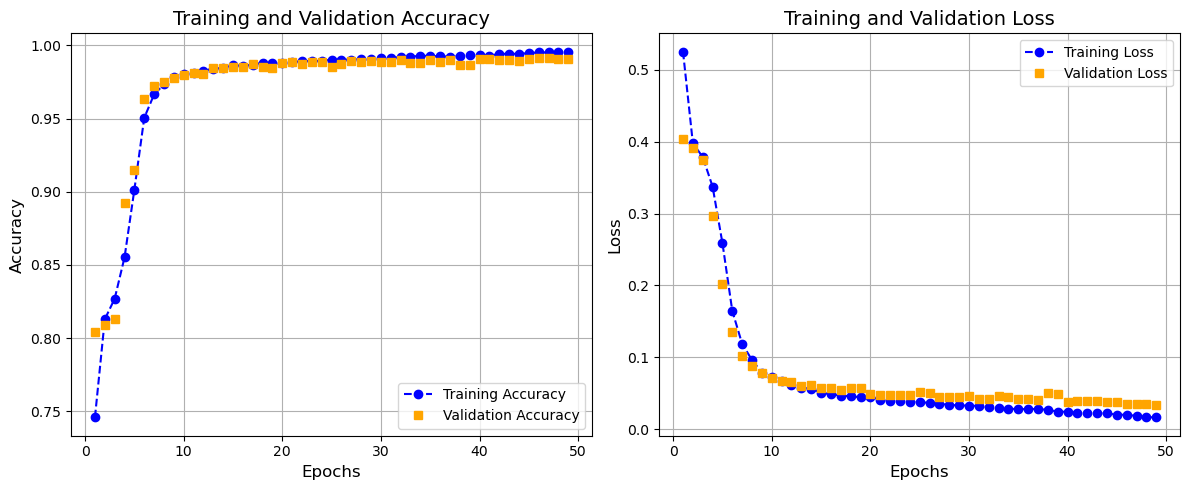

<Figure size 640x480 with 0 Axes>

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
    
epochs = range(1, len(acc) + 1)  # Number of epochs

# Creating a figure with two subplots (1 row, 2 columns)
plt.figure(figsize=(12, 5))

# Plot Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'go--',color='blue', label='Training Accuracy')
plt.plot(epochs, val_acc, 'rs',color='orange', label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# Plot Loss Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'go--', color='blue', label='Training Loss')
plt.plot(epochs, val_loss, 'rs', color='orange', label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()
plt.savefig("acc_loss_.png")

In [43]:
# predicton for test set
pred = model.predict(testX)

86/86 ━━━━━━━━━━━━━━━━━━━━ 44s 501ms/step


In [44]:
print(pred.shape)

(2738, 1)


In [45]:
# Threshold values predicted

for i in range(len(pred)):
    if pred[i] > 0.5:
        pred[i]=1
    elif pred[i] <= 0.5:
        pred[i]=0

In [46]:
# Count True predicted and wrong predicted

true = 0
false = 0

for i in range(len(pred)):
    if pred[i] == testY[i]:
        true+=1
    else:
        false+=1

print("correct prediction :: ", true)
print("false prediction :: ",false)

correct prediction ::  2713
false prediction ::  25


In [47]:
# Number of attack and benign data in test set 

attack = 0 
benign = 0

for i in range(len(testY)):
    if testY[i] == 1:
        attack+=1
    else:
        benign+=1

print("Attack data in test set :: ", attack)
print("Benign data in test set :: ", benign)

Attack data in test set ::  1478
Benign data in test set ::  1260


# Confusion Matrix

In [49]:
# Takes True positive , true negative , false positive and false negative as input 
# Returns Accuracy

def accuracy_function(tp,tn,fp,fn):
    accuracy = (tp+tn) / (tp+tn+fp+fn)
    return accuracy

In [50]:
# Takes True Positive and false Positive 
# Returns Precision

def precision_function(tp,fp):
    precision = tp / (tp+fp)
    return precision

In [51]:
# Takes True Positive and false negative
# Return Recall

def recall_function(tp,fn):
    recall = tp/(tp+fn)
    return recall

In [52]:
# Takes true values and predicted
# Returns Accuracy , precision and recall

def confusion_matrix(truth , predicted):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    
    for true,pred in zip(truth,predicted):
        if true == 1:
            if pred == true:
                true_positive += 1
            elif pred != true:
                false_negative += 1
        elif true == 0:
            if pred == true:
                true_negative += 1
            elif pred != true:
                false_positive += 1
    accuracy = accuracy_function(true_positive,true_negative,false_positive,false_negative)
    precision = precision_function(true_positive, false_positive)
    recall = recall_function(true_positive, false_negative)
    return (accuracy, precision, recall)

In [53]:
accuracy,precision,recall = confusion_matrix(testY, pred)

In [54]:
print("Accuracy : {0} \n Precision : {1} \n Recall : {2}".format(accuracy,precision,recall))


Accuracy : 0.9908692476260044 
 Precision : 0.9892255892255892 
 Recall : 0.9939106901217862


86/86 ━━━━━━━━━━━━━━━━━━━━ 48s 561ms/step


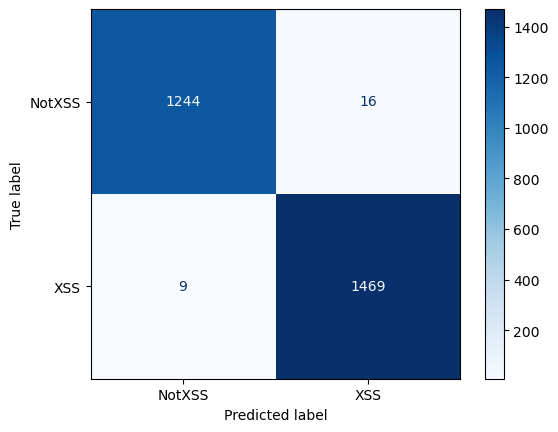

In [55]:
#trainX, testX, trainY, testY
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = (model.predict(testX)>0.5).astype(int)
cm = confusion_matrix(testY,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['NotXSS','XSS'])
disp.plot(cmap=plt.cm.Blues)
plt.show()